In [1]:
import os
from pipeline_functionality import preprocess_data
from pipeline_functionality import preprocess_training_validation
from pipeline_functionality import feature_engineering
from pipeline_functionality import NeuralNetwork
from pipeline_functionality import TrainingValidatingNetwork
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
from imblearn.over_sampling import SMOTE
from scipy.stats import f_oneway
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Functions for Statistical Tests for feature engineering and EDA

In [2]:
#One way ANOVA test
def oneway_anova(class1,class2):
    stat,pval = f_oneway(class1,class2)
    if pval < 0.05:
        print(f"Mean difference is statistically significant with pvalue of {pval}")
    else:
        print(f"Mean difference is statistically not significant with pvalue of {pval}")

#chi2 test
def check_chi2_correlation(contingency_table):
    DOF = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
    critical_val = chi2.ppf(0.95,DOF)
    stat,p,dof,expected_array = chi2_contingency(contingency_table)
    if stat > critical_val:
        print(f"Reject Null Hypotheses. Critical Value for 0.95 siginficance : {critical_val}, DOF : {DOF}. Chi2 statistic : {stat}")
    else:
        print(f"No correlation. Critical Value for 0.95 siginficance : {critical_val}. Chi2 statistic : {stat}")

In [3]:
preprocess = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df = preprocess.read_df()

Checking for missing values

In [4]:
df.isna().sum()

Feature 0     1
Feature 1     1
Feature 2     0
Feature 3     0
Feature 4     0
Feature 5     0
Feature 6     0
Feature 7     0
Age           0
Sex           0
Feature 10    1
label         0
dtype: int64

In [5]:
df[(df["Feature 0"].isna()) & (df["Feature 1"].isna()) & (df["Feature 10"].isna())]

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Sex,Feature 10,label
39,NaN,NaN,1336.54,739.71,550.3,68.46,192.07,1615.68,21,0,NaN,0


There is only one instance of missing values, hence we shall drop that off

In [6]:
df = df.dropna(subset=["Feature 0","Feature 1","Feature 10"])
df

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Sex,Feature 10,label
0,3556.0,2489.0,265.19,77.53,176.55,0.00,4.20,307.91,52,0,7515.0,1
1,1906.0,134.0,1442.61,551.90,876.07,112.10,168.15,1735.48,20,1,1756.0,0
2,1586.0,71.0,1332.74,684.20,655.26,244.95,216.52,1820.04,28,1,1311.0,0
3,683.0,94.0,419.23,255.80,162.17,72.05,44.68,538.22,55,1,1443.0,0
4,1032.0,71.0,1102.72,480.27,625.30,188.78,130.77,1427.97,28,1,1542.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82,626.0,68.0,1771.57,666.99,1117.48,360.21,118.84,2306.82,42,1,1521.0,0
83,1237.0,71.0,1348.53,428.09,924.69,120.02,48.67,1524.78,56,0,1345.0,0
84,634.0,1002.0,1300.00,558.00,724.00,67.00,105.00,1484.26,34,0,2926.0,1
85,112.0,884.0,942.83,378.49,567.06,116.77,31.81,1104.59,33,1,2352.0,1


In [7]:
df = df.reset_index(drop=True)

Counts of the different labels

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Number of 0:  57
Number of 1:  29


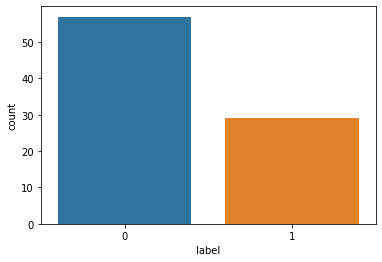

In [8]:
sns.countplot(df["label"],label = "Count")
B, M = df["label"].value_counts()
print('Number of 0: ',B)
print('Number of 1: ',M)

Separating Train and Label arrays

In [9]:
df_train = df[[i for i in df.columns.tolist() if i!="label"]]
df_label = df[[i for i in df.columns.tolist() if i=="label"]]

EDA will be done on a smaller subset of the dataset, while cross validation will be done using K Fold Cross Validation. 
From the results of EDA, the pipeline will be made to process the entire dataset as per the findings of EDA

In [10]:
df_eda,df_validation,y_eda,y_validation = train_test_split(df_train,df_label,test_size = 0.2, random_state=42,stratify=df_label)

In [11]:
df_eda["label"] = y_eda

In [12]:
df_eda.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Sex,Feature 10,label
34,821.0,134.0,1134.74,741.00,401.00,459.72,23.87,1619.77,41,1,1893.0,0
26,2088.0,98.0,962.30,533.03,459.72,370.88,142.89,1477.31,51,1,1599.0,1
7,2623.0,126.0,642.98,329.66,316.59,167.89,85.38,899.51,41,0,1620.0,0
81,626.0,68.0,1771.57,666.99,1117.48,360.21,118.84,2306.82,42,1,1521.0,0
18,2506.0,198.0,1865.46,792.76,1096.75,271.73,166.75,2329.09,20,1,2096.0,0


In [13]:
df_eda_melt = pd.melt(df_eda,id_vars='label',var_name='features',value_name='values')

<h3>Feature Engineering</h3>

- Violin plots on each feature to identify the features that cause the best class separation
- Use Swarm plots too
- One way Anova tests to identify which features have statistically significant differences in feature
- Correlation between each feature to be investigated

Drawing Violin Plots for each feature at hand

<AxesSubplot:xlabel='features', ylabel='values'>

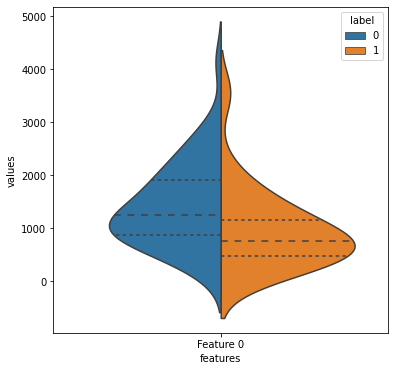

In [14]:
fig,ax_feature1 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 0"])],split = True,ax = ax_feature1,inner='quartile')

In [15]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 0"],df_eda.loc[df_eda["label"] == 1]["Feature 0"])

Mean difference is statistically significant with pvalue of 0.023935305587587413


Conclusion:

Feature 0: MO HLADR+ MFI (cells/ul)

The mean value of each class for Feature 0 is significantly different. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

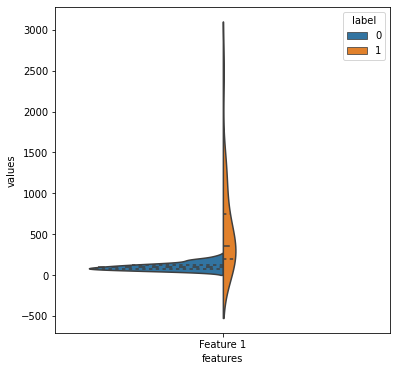

In [16]:
fig,ax_feature2 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 1"])],split = True,ax = ax_feature2,inner='quartile')

In [17]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 1"],df_eda.loc[df_eda["label"] == 1]["Feature 1"])

Mean difference is statistically significant with pvalue of 6.231848136249714e-07


Conclusion:

Feature 1: Neu CD64+MFI (cells/ul)

The mean value of each class for Feature 1 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels. As seen in the violin plot, it is clear that label 0 only exists in a small range of values, while label 1 exists in a larger range. This can be used to create a categorical variable for Feature 1.

<AxesSubplot:xlabel='features', ylabel='values'>

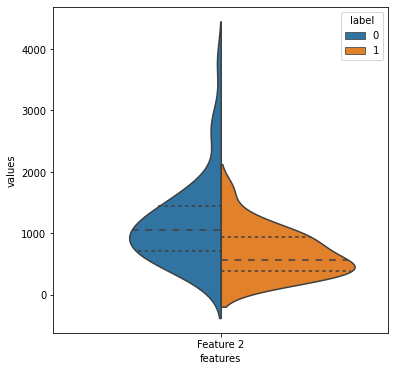

In [18]:
fig,ax_feature3 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 2"])],split = True,ax = ax_feature3,inner='quartile')

In [19]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 2"],df_eda.loc[df_eda["label"] == 1]["Feature 2"])

Mean difference is statistically significant with pvalue of 0.0028437537923969997


Conclusion:

Feature 2: CD3+T (cells/ul)

The mean value of each class for Feature 2 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

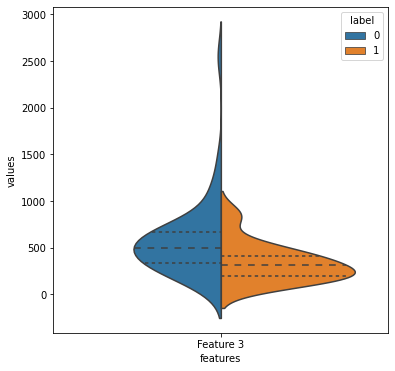

In [20]:
fig,ax_feature4 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 3"])],split = True,ax = ax_feature4,inner='quartile')

In [21]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 3"],df_eda.loc[df_eda["label"] == 1]["Feature 3"])

Mean difference is statistically significant with pvalue of 0.010454126774601379


Conclusion:

Feature 3: CD8+T (cells/ul)

The mean value of each class for Feature 3 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

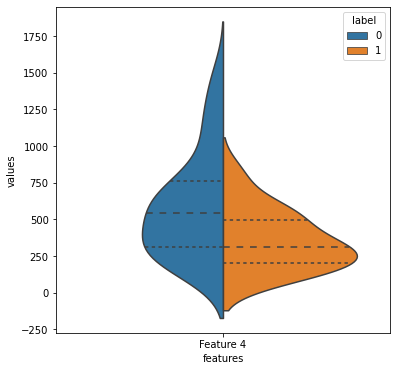

In [22]:
fig,ax_feature5 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 4"])],split = True,ax = ax_feature5,inner='quartile')

In [23]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 4"],df_eda.loc[df_eda["label"] == 1]["Feature 4"])

Mean difference is statistically significant with pvalue of 0.005129355965414621


Conclusion:

Feature 4: CD4+T (cells/ul)

The mean value of each class for Feature 4 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

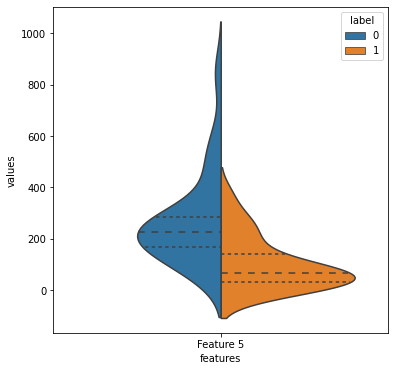

In [24]:
fig,ax_feature6 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 5"])],split = True,ax = ax_feature6,inner='quartile')

In [25]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 5"],df_eda.loc[df_eda["label"] == 1]["Feature 5"])

Mean difference is statistically significant with pvalue of 8.502059872383942e-05


Conclusion:

Feature 5: NK (cells/ul)

The mean value of each class for Feature 5 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels. We can see that 75% of all class 1 cases occur before the 25th percentile value of label 0. Hence we can create a new categorical variable on label 1 which labels training instances as high risk if NK (cells/ul) is below the 75th percentile line of Feature 5 with respect to label 1.

<AxesSubplot:xlabel='features', ylabel='values'>

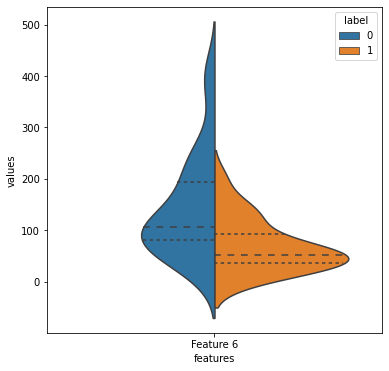

In [26]:
fig,ax_feature7 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 6"])],split = True,ax = ax_feature7,inner='quartile')

In [27]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 6"],df_eda.loc[df_eda["label"] == 1]["Feature 6"])

Mean difference is statistically significant with pvalue of 0.001172085754178186


Conclusion:

Feature 6: CD19+ (cells/ul)

The mean value of each class for Feature 6 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

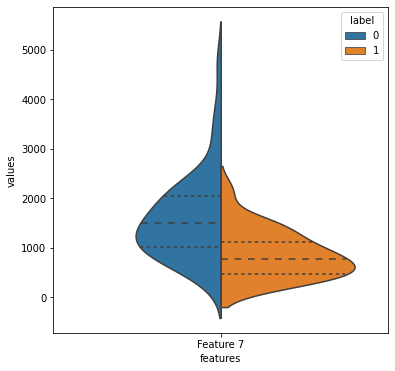

In [28]:
fig,ax_feature8 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 7"])],split = True,ax = ax_feature8,inner='quartile')

In [29]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 7"],df_eda.loc[df_eda["label"] == 1]["Feature 7"])

Mean difference is statistically significant with pvalue of 0.00035249089766524954


Conclusion:

Feature 7: CD45+ (cells/ul)

The mean value of each class for Feature 7 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels. We can see that 75% of all class 1 cases occur before the 25th percentile value of label 0. Hence we can create a new categorical variable on label 1 which labels training instances as high risk if CD45+ (cells/ul) is below the 75th percentile line of Feature 7 with respect to label 1.

<AxesSubplot:xlabel='features', ylabel='values'>

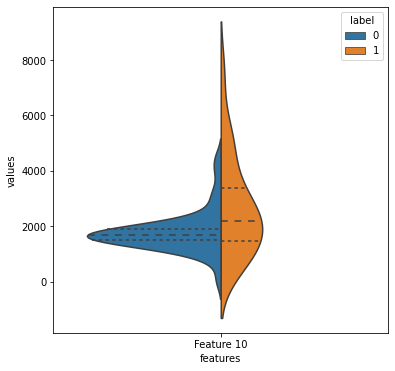

In [30]:
fig,ax_feature9 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 10"])],split = True,ax = ax_feature9,inner='quartile')

In [31]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 10"],df_eda.loc[df_eda["label"] == 1]["Feature 10"])

Mean difference is statistically significant with pvalue of 0.0061543755802451194


Conclusion:

Feature 10: Mono CD64+MFI (cells/ul)

The mean value of each class for Feature 10 is significantly different. Hence it can act as a good feature to separate classification of labels. 

From the above analysis, the features other than Feature 0 and Feature 10, can act as very good features to do classification on. While Feature 0 and Feature 10 are satistically different in mean, their p values are not low compared to the other Features

Age

<AxesSubplot:xlabel='features', ylabel='values'>

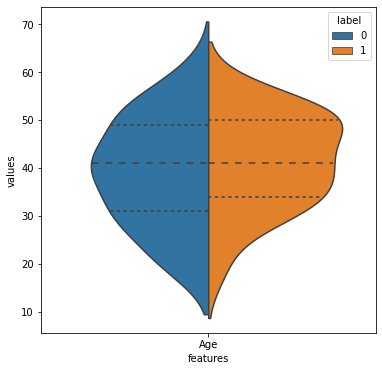

In [32]:
fig,ax_feature10 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Age"])],split = True,ax = ax_feature10,inner='quartile')

In [33]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Age"],df_eda.loc[df_eda["label"] == 1]["Age"])

Mean difference is statistically not significant with pvalue of 0.4257126077655161


Conclusion:

Feature: Age

The mean value of each class for Age is not significantly different as seen by both the violin plot and the pvalue of the ANOVA test, which is grester than 0.05.

Sex

<AxesSubplot:xlabel='Sex', ylabel='count'>

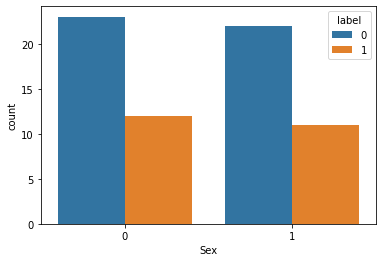

In [34]:
sns.countplot(x = "Sex",hue = "label",data = df_eda) 

In [35]:
check_chi2_correlation(pd.crosstab(df_eda["Sex"],df_eda["label"]))

No correlation. Critical Value for 0.95 siginficance : 3.841458820694124. Chi2 statistic : 0.0


Conclusion

As seen above and proved by the Chi2 test for the categorical variables, there is no useful split between 0 and 1 labels between the 2 genders. 

<h3>Plotting Swarm plots to visualize the distribution of instances for each feature</h3>
Swarm plots can show which continuous features allow for good separation of labels. 

Feature 0 : MO HLADR+ MFI (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

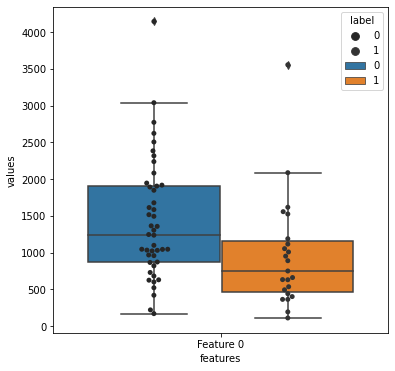

In [36]:
fig,ax_swarm1 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 0"])],split = True,ax = ax_swarm1,color = ".2")
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 0"])],ax = ax_swarm1)

Feature 1 : Neu CD64+MFI (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

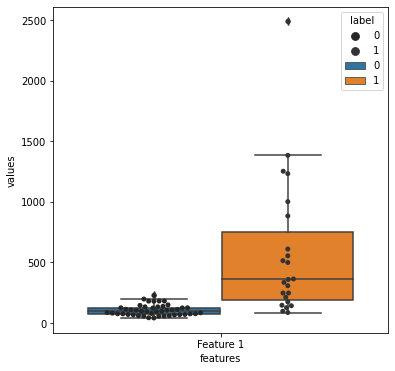

In [37]:
fig,ax_swarm2 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 1"])],split = True,ax = ax_swarm2,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 1"])],ax = ax_swarm2)

Feature 2 : CD3+T (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

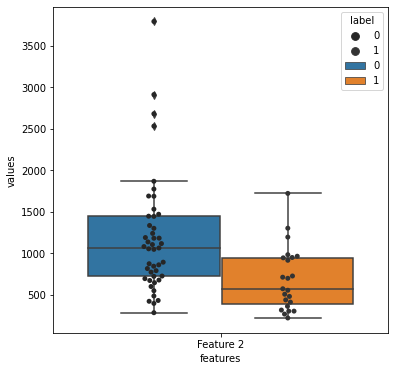

In [38]:
fig,ax_swarm3 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 2"])],split = True,ax = ax_swarm3,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 2"])],ax = ax_swarm3)

Feature 3 : CD8+T (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

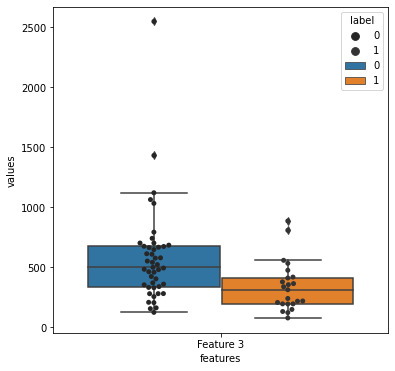

In [39]:
fig,ax_swarm4 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 3"])],split = True,ax = ax_swarm4,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 3"])],ax = ax_swarm4)

Feature 4 : CD4+T (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

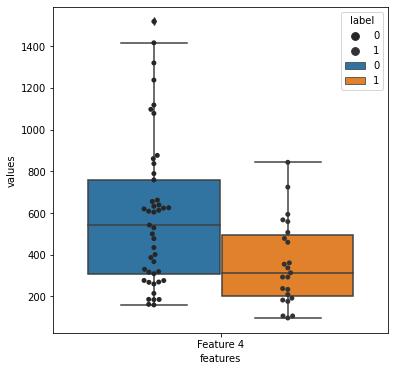

In [40]:
fig,ax_swarm5 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 4"])],split = True,ax = ax_swarm5,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 4"])],ax = ax_swarm5)

Feature 5 : NK (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

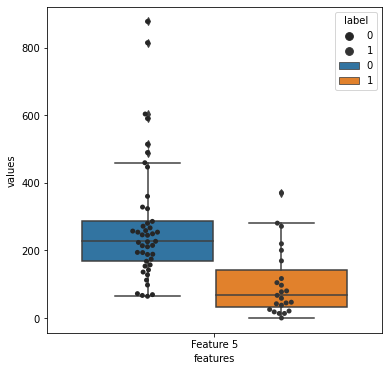

In [41]:
fig,ax_swarm6 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 5"])],split = True,ax = ax_swarm6,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 5"])],ax = ax_swarm6)

Feature 6 : CD19+ (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

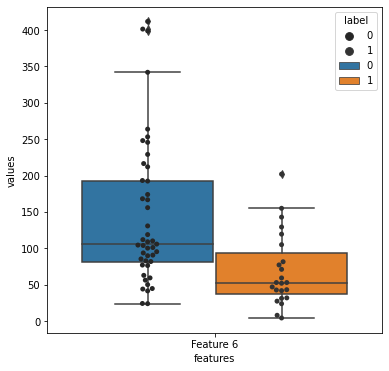

In [42]:
fig,ax_swarm7 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 6"])],split = True,ax = ax_swarm7,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 6"])],ax = ax_swarm7)

Feature 7 : CD45+ (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

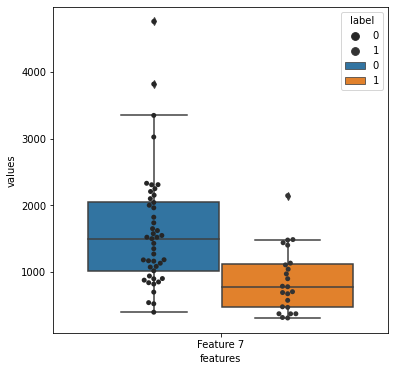

In [44]:
fig,ax_swarm8 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 7"])],split = True,ax = ax_swarm8,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 7"])],ax = ax_swarm8)

Feature 10: Mono CD64+MFI (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

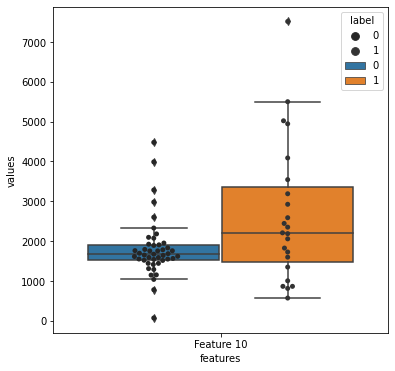

In [45]:
fig,ax_swarm9 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 10"])],split = True,ax = ax_swarm9,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 10"])],ax = ax_swarm9)

Insight from Exploratory Data Analysis:

Features 0 show similar distributions between both classes and no useful separation. 

Features 2,3,4 show similar distributions between both classes and no useful separation. Also these 3 features show very similar distributions for each feature itself. This suggests high correlation. 

Feature 6,7 show similar distributions between both classes and no useful separation. 

Feature 1 shows that all instances of class label 0 are much lower than that of class label 1. Hence we can create a categorical attribute of high risk and low risk.

Feature 5 shows that all instances of class label 1 are concentrated below the 75th percentile. Hence we can create a categorical attribute with this feature anything below the 75th pecentile of Class label 1 is considered as high risk. 

In Feature 10, majority of the instances of class Label 0 are concentrated betwee the 25th and 75th percentiles hence all values of the 10th Feature below the 75th percentile can be considered as low risk. 

Feature engineering

1) New categorical attribute will be created using feature 1. The instances with Feature 1 values < the 75th Percentile + 1.5IQR of feature 1 in class 0 will be considered as low risk

2) New categorical attribute will be created using feature 5. The instances with Feature 5 values < the 75th Percentile feature 5 in class 1 will be considered as high risk

3) New categorical attribute will be created using feature 10. The instances with Feature 10 values < the 75th Percentile feature 10 in class 0 will be considered as low risk

First we shall model without any Feature Engineering

Oversampling is used

In [46]:
preprocess_training_plain = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df_plain = preprocess_training_plain.read_df(process_complete=True,feature_eng=False,oversampling=True)
df_test_plain = preprocess_training_plain.read_df(process_complete=True,test_df=True, test_path=str(Path(Path.cwd()/"Data"/"test.csv").resolve()))

In [47]:
df_train_plain = df_plain[[i for i in df_plain.columns.tolist() if i != "label"]]
df_labels_plain = df_plain[["label"]]

First we test a Neural Network with two layers

Hyperparameter tuning of the number of units in the first and second layer

In [48]:
first_layer_output = [15,16,17,18,19,20]
second_layer_output =[6,7,8,9]
combinations = list(product([i for i,j in enumerate(first_layer_output)],[i for i,j in enumerate(second_layer_output)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([first_layer_output[combination[0]],second_layer_output[combination[1]]])

Training a neural network on the dataset with no feature engineering

In [49]:
accuracy_list_plain = list()
for parameter_set in parameter_list:
# for units in first_layer_output:
    first_layer_output_units = parameter_set[0]
    second_layer_output_units = parameter_set[1]
    epoch_num = 10
    cross_val_splits = 5

    ksplitter = StratifiedKFold(n_splits = 5, shuffle = True,random_state = 42)
    model_score = 0
    model_loss = 0
    #KFold cross validation used with stratification to ensure equal label distribution among splits
    for train_idx,valid_idx in ksplitter.split(df_train_plain,df_labels_plain):
        layer_info_dict = {
            1:(df_train_plain.shape[1],first_layer_output_units,'elu'),
            # 1:(df_train.shape[1],units,'relu'),
            2:(first_layer_output_units,second_layer_output_units,'elu'),
            #output layer
            # 3:(second_layer_output_units,4,'elu'),
            3:(second_layer_output_units,1,'sigmoid')
        }
        
        model = NeuralNetwork(layer_info_dict)
        loss_fn = nn.BCELoss()
        X_train,y_train = df_train_plain.to_numpy()[train_idx],df_labels_plain.to_numpy()[train_idx]
        X_valid,y_valid = df_train_plain.to_numpy()[valid_idx],df_labels_plain.to_numpy()[valid_idx]

        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        trainvalidate = TrainingValidatingNetwork()
        optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
        accuracy,loss,model = trainvalidate.train_and_validate(train_dataloader,valid_dataloader,model,loss_fn,epochs=10,optimizer=optimizer)       
        model_score += accuracy
        model_loss += loss
    print(f"Done First Layer: {first_layer_output_units} and Second Layer:{second_layer_output_units}. Accuracy : {model_score/cross_val_splits}. Split Size : {train_idx.shape[0]}")
    accuracy_list_plain.append((first_layer_output_units,second_layer_output_units,model_score/cross_val_splits,model))
    # accuracy_list.append((units,model_score/cross_val_splits))
    # print(f"First Layer : {first_layer_output_units}, Second Layer: {second_layer_output_units}, Accuracy : {model_score/cross_val_splits}, Loss: {model_loss/cross_val_splits}")

Done First Layer: 15 and Second Layer:6. Accuracy : 0.8679841897233201. Split Size : 92
Done First Layer: 15 and Second Layer:7. Accuracy : 0.8679841897233201. Split Size : 92
Done First Layer: 15 and Second Layer:8. Accuracy : 0.8588932806324111. Split Size : 92
Done First Layer: 15 and Second Layer:9. Accuracy : 0.8679841897233201. Split Size : 92
Done First Layer: 16 and Second Layer:6. Accuracy : 0.8588932806324111. Split Size : 92
Done First Layer: 16 and Second Layer:7. Accuracy : 0.850197628458498. Split Size : 92
Done First Layer: 16 and Second Layer:8. Accuracy : 0.8588932806324111. Split Size : 92
Done First Layer: 16 and Second Layer:9. Accuracy : 0.8588932806324111. Split Size : 92
Done First Layer: 17 and Second Layer:6. Accuracy : 0.8679841897233201. Split Size : 92
Done First Layer: 17 and Second Layer:7. Accuracy : 0.8679841897233201. Split Size : 92
Done First Layer: 17 and Second Layer:8. Accuracy : 0.867588932806324. Split Size : 92
Done First Layer: 17 and Second La

In [50]:
y_pred_list_train_noeng = list()
y_pred_list_test_noeng = list()
train_plain_np = df_train_plain.to_numpy()
test_plain_np = df_test_plain.to_numpy()
model_final_plain = sorted(accuracy_list_plain,key = lambda x:x[2],reverse=True)[0][3]

with torch.no_grad():
    for i in train_plain_np:
        y_pred_list_train_noeng.append(model_final_plain(torch.tensor(i).float()).round().detach().numpy()[0])


with torch.no_grad():
    for j in test_plain_np:
        y_pred_list_test_noeng.append(model_final_plain(torch.tensor(j).float()).round().detach().numpy()[0])

In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(df_labels_plain.to_numpy().reshape(-1,),np.array(y_pred_list_train_noeng))

0.8947368421052632

Submission : Neural Network with no Feature Engineering



In [52]:
df_data = {'id':list(range(len(y_pred_list_test_noeng))),'label':[int(i) for i in y_pred_list_test_noeng]}
pd.DataFrame(df_data).to_csv("Submission.csv")

Random Forest Trained on the plain dataset with no Feature Engineering

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
parameters = {
    'n_estimators':[10,50,100,200,300,400,500,1000],
    'max_depth':[10,15,20],
    'max_features':[4,5,6,7]
}

scoring = {"Accuracy":make_scorer(accuracy_score)}

randforest = RandomForestClassifier(random_state=42)


# rands = RandomizedSearchCV(estimator=randforest,param_distributions=parameters,scoring = scoring,refit = "Accuracy",cv = 5, return_train_score=True,random_state=42)
rands = GridSearchCV(estimator=randforest,param_grid=parameters,scoring=scoring,refit = "Accuracy",cv = 5,return_train_score=True,verbose=1)

rands.fit(df_train_plain.to_numpy(),df_labels_plain.to_numpy().reshape(-1,))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': [4, 5, 6, 7],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500,
                                          1000]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=1)

In [62]:
y_pred = rands.best_estimator_.predict(df_train_plain.to_numpy())
accuracy_score(df_labels_plain.to_numpy().reshape(-1,),y_pred)

1.0

In [63]:
rands.best_params_

{'max_depth': 10, 'max_features': 4, 'n_estimators': 200}

Submission with Random Forest (No Feature Engineering)

Contains oversampling and achieves a submission score of 0.96551(Submission 2)

In [64]:
y_test_pred = rands.best_estimator_.predict(df_test_plain.to_numpy())
df_data = {'id':list(range(y_test_pred.shape[0])),'label':y_test_pred.tolist()}
pd.DataFrame(df_data).to_csv("Submission.csv")

Random Forest on data with no scaling

In [65]:
preprocess_training_plain = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df_plain_noscale = preprocess_training_plain.read_df(process_complete=True,feature_eng=False,oversampling=True,scaling=False)
df_test_plain_noscale = preprocess_training_plain.read_df(process_complete=True,test_df=True, test_path=str(Path(Path.cwd()/"Data"/"test.csv").resolve()),scaling=False)
df_train_plain_noscale = df_plain_noscale[[i for i in df_plain_noscale.columns.tolist() if i != "label"]]
df_labels_plain_noscale = df_plain_noscale[["label"]]

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
parameters = {
    'n_estimators':[10,50,100,150],
    'max_depth':[3,5,8],
    'max_features':[1,2,3,4]
}

scoring = {"Accuracy":make_scorer(accuracy_score)}

randforest = RandomForestClassifier(random_state=42)


# rands = RandomizedSearchCV(estimator=randforest,param_distributions=parameters,scoring = scoring,refit = "Accuracy",cv = 5, return_train_score=True,random_state=42)
rands_noscale = GridSearchCV(estimator=randforest,param_grid=parameters,scoring=scoring,refit = "Accuracy",cv = 5,return_train_score=True,verbose=1)

rands_noscale.fit(df_train_plain_noscale.to_numpy(),df_labels_plain_noscale.to_numpy().reshape(-1,))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 8], 'max_features': [1, 2, 3, 4],
                         'n_estimators': [10, 50, 100, 150]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=1)

In [67]:
rands_noscale.best_params_

{'max_depth': 8, 'max_features': 4, 'n_estimators': 100}

Submission for Random forest with Non Scaled Data

In [68]:
y_test_pred = rands.best_estimator_.predict(df_test_plain.to_numpy())
df_data = {'id':list(range(y_test_pred.shape[0])),'label':y_test_pred.tolist()}
pd.DataFrame(df_data).to_csv("Submission.csv")

Contains oversampling and no scaling. Achieves score of 0.96551(Submission 3)

Incorporate Feature Engineering

Random Forest trained with Feature Engineering

In [70]:
preprocess_training = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df_engineered = preprocess_training.read_df(process_complete = True,feature_eng=True)
df_train_engineered = df_engineered[[i for i in df_engineered.columns.tolist() if i not in ["label"]]]
df_labels_engineered = df_engineered[[i for i in df_engineered.columns.tolist() if i in ["label"]]]

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
parameters = {
    'n_estimators':[10,50,100,150],
    'max_depth':[3,5,8],
    'max_features':[2,3,4]
}

scoring = {"Accuracy":make_scorer(accuracy_score)}

randforest = RandomForestClassifier(random_state=42)


# rands = RandomizedSearchCV(estimator=randforest,param_distributions=parameters,scoring = scoring,refit = "Accuracy",cv = 5, return_train_score=True,random_state=42)
rands_eng = GridSearchCV(estimator=randforest,param_grid=parameters,scoring=scoring,refit = "Accuracy",cv = 5,return_train_score=True,verbose=1)

rands_eng.fit(df_train_engineered.to_numpy(),df_labels_engineered.to_numpy().reshape(-1,))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 8], 'max_features': [2, 3, 4],
                         'n_estimators': [10, 50, 100, 150]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=1)

Submission : Random Forest with Feature Engineering

In [72]:
y_test_pred = rands_eng.best_estimator_.predict(df_test_plain.to_numpy())
df_data = {'id':list(range(y_test_pred.shape[0])),'label':y_test_pred.tolist()}
pd.DataFrame(df_data).to_csv("Submission.csv")

Contains feature engineering and scaling. Achieves score of 0.82758(Submission 3)

Conclusion

- Extrapolatory Data Analysis was done to identify Features with the highest separation potential
- One way Anova Tests and Chi Square tests were used to statistically confirm judgement
- Feature Engineering was carried out
- Models were built using random forests and neural networks
- The best performing models were found to be that without Feature Engineering
- Random forests performed better than neural networks